In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils

In [2]:
# Load results of the fitting procedure

subject = 1
volume_space=True
fitting_type = 'gabor_solo_ridge_4ori_4sf'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True);
load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_4ori_4sf/Sep-20-2021_1819_56/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'feature_table_simple', 'filter_pars_simple', 'orient_filters_simple', 'feature_table_complex', 'filter_pars_complex', 'orient_filters_complex', 'feature_types_exclude', 'feature_info', 'nonlin_fn', 'padding_mode', 'autocorr_output_pix', 'group_all_hl_feats'])
subject = 1
volume_space = 1
fitting_type = gabor_solo
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (7500,)
voxel_index: len 1
voxel_roi: len 2
voxel_ncsnr: shape (699192,)
aperture = 1.0
aperture_rf_

In [3]:
out.keys()

dict_keys(['subject', 'volume_space', 'fitting_type', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'feature_table_simple', 'filter_pars_simple', 'orient_filters_simple', 'feature_table_complex', 'filter_pars_complex', 'orient_filters_complex', 'feature_types_exclude', 'feature_info', 'nonlin_fn', 'padding_mode', 'autocorr_output_pix', 'group_all_hl_feats'])

In [4]:
cyc_per_stim = np.array(out['feature_table_complex']['SF: cycles per stim'])
cyc_per_stim = np.unique(cyc_per_stim)

In [5]:
orients_deg = np.array(out['feature_table_complex']['Orientation: degrees'])
orients_deg = np.unique(orients_deg)

In [6]:
feature_weights = out['best_params'][1][:,:,0]
n_voxels = feature_weights.shape[0]
n_ori = len(np.unique(orients_deg))
n_sf = len(np.unique(cyc_per_stim))
allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')
mean_orient_weights = np.mean(allw_reshaped, axis=2)
print(np.shape(mean_orient_weights))
mean_sf_weights = np.mean(allw_reshaped, axis=1)
print(np.shape(mean_sf_weights))

(14913, 4)
(14913, 4)


In [50]:
retlabs[vidx]

0.0

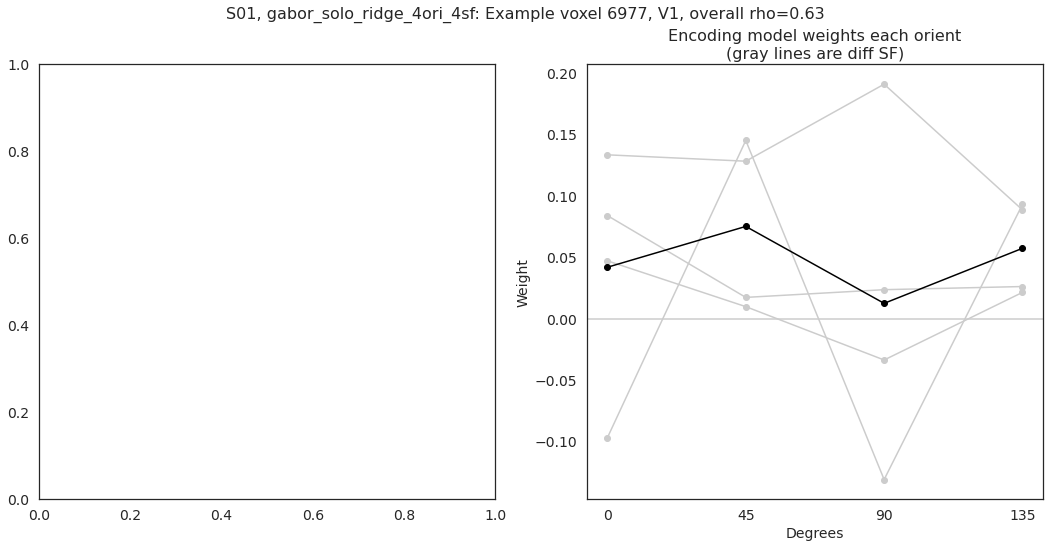

In [57]:
# Plotting orientation tuning for one example voxel

val_cc = out['val_cc'][:,0]
orients_deg
vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance
if ~np.isnan(retlabs[vidx]):
    rname = ret_names[int(retlabs[vidx])]
elif ~np.isnan(facelabs[vidx]):
    rname = face_names[int(facelabs[vidx])]
elif ~np.isnan(placelabs[vidx]):
    rname = place_names[int(placelabs[vidx])]
elif ~np.isnan(bodylabs[vidx]):
    rname = body_names[int(bodylabs[vidx])]
else:
    raise ValueError('vidx not found')
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
# plt.plot(orients_deg, allcorrs_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
# plt.plot(orients_deg,  mean_orient_corrs[vidx,:],'-o',color='k')
# plt.xlabel('Degrees')
# plt.ylabel('Correlation')
# plt.title('Correlation of voxel response and activation each orient channel\n(gray lines are diff SF)')
# # plt.axhline(val_cc[vidx],color='k')
# plt.axhline(0, color=[0.8, 0.8, 0.8])
# plt.xticks(np.arange(0,179,45))
# plt.ylim([-0.5,1])

plt.subplot(1,2,2)
plt.plot(orients_deg, allw_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg, mean_orient_weights[vidx,:],'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Weight')
plt.title('Encoding model weights each orient\n(gray lines are diff SF)')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
# plt.ylim([-1,1])

plt.suptitle('S%02d, %s: Example voxel %d, %s, overall rho=%.2f'%( subject, \
               fitting_type, vidx, rname, val_cc[vidx]),fontsize=16);



In [7]:
from utils import nsd_utils, roi_utils, default_paths

from model_fitting import initialize_fitting as initialize_fitting

In [8]:
feature_types_exclude = ['pixel', 'simple_feature_means', 'autocorrs', 'crosscorrs']
name1 = 'gabor_solo'

In [9]:
# decide what voxels to use  
up_to_sess = 1;
shuffle_images = False
random_images = False
random_voxel_data = False

voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, \
                                                        volume_space, include_all=True, include_body=True)

sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
image_inds_only = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, \
        image_order, image_order_trn, image_order_val = nsd_utils.get_data_splits(subject, \
                                  sessions=sessions, image_inds_only = image_inds_only, \
                                  voxel_mask=voxel_mask, volume_space=volume_space, \
                                  zscore_betas_within_sess=zscore_betas_within_sess, \
                              shuffle_images=shuffle_images, random_images=random_images, \
                                random_voxel_data=random_voxel_data)

if image_inds_only==True:
    # For this model, the features are pre-computed, so we will just load them rather than passing in images.
    # Going to pass the image indices (into 10,000 dim array) instead of images to fitting and val functions, 
    # which will tell which features to load.
    trn_stim_data = image_order_trn
    val_stim_data = image_order_val


Volume space: ROI defs are located at: /lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/subj01/func1pt8mm/roi

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
unique values in face labels:
[-1.  0.  1.  2.  3.  5.]
unique values in place labels:
[-1.  0.  1.  2.  3.]
unique values in body labels:
[-1.  0.  1.  2.  3.]
1987 voxels are defined (differently) in both retinotopic areas and category areas
0 voxels are defined (differently) in both face areas and place areas
490 voxels are defined (differently) in both face areas and body areas
158 voxels are defined (differently) in both place areas and body areas
Including all voxels that are defined within nsdgeneral mask, in addition to roi labels.

19738 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all

In [10]:
which_prf_grid=1
zscore_features=False
ridge=True
# More params for fitting
holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge)
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range, which_grid=which_prf_grid) 



Possible lambda values are:
[1.00000000e-06 7.49894209e-06 5.62341325e-05 4.21696503e-04
 3.16227766e-03 2.37137371e-02 1.77827941e-01 1.33352143e+00
 1.00000000e+01]
number of pRFs: 875
most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [11]:
# Set up the Gabor filtering modules
device = 'cpu:0'
from feature_extraction import texture_statistics_gabor
do_varpart=False
group_all_hl_feats=False
_gabor_ext_complex, _gabor_ext_simple, _fmaps_fn_complex, _fmaps_fn_simple = \
        initialize_fitting.get_gabor_feature_map_fn(n_ori, n_sf,device=device);    
# Initialize the "texture" model which builds on first level feature maps
autocorr_output_pix=5
compute_features = False
_feature_extractor = texture_statistics_gabor.texture_feature_extractor(_fmaps_fn_complex, _fmaps_fn_simple, \
                                                                        subject=subject,\
                                        autocorr_output_pix=autocorr_output_pix, \
                                        feature_types_exclude=feature_types_exclude, do_varpart=do_varpart, \
                                        group_all_hl_feats=group_all_hl_feats, compute_features = compute_features, \
                                                                        device=device)      
feature_info = [_feature_extractor.feature_column_labels, _feature_extractor.feature_types_include]

Feature types to exclude from the model:
['pixel', 'simple_feature_means', 'autocorrs', 'crosscorrs', 'complex_within_scale_crosscorrs', 'simple_within_scale_crosscorrs', 'complex_across_scale_crosscorrs', 'simple_across_scale_crosscorrs', 'complex_feature_autocorrs', 'simple_feature_autocorrs', 'pixel_stats']


In [13]:
_feature_extractor.prf_batch_size = 1;

In [14]:
best_params = out['best_params']
image_size = None
_feature_extractor.init_for_fitting(image_size=image_size, models=models, dtype=fpX)

In [252]:
len(_feature_extractor.feature_types_include)==1 and _feature_extractor.feature_types_include[0]=='complex_feature_means'

True

In [253]:
_feature_extractor.max_features

16

In [15]:
prf_models = models;
voxel_data = val_voxel_data;
images = val_stim_data;
zscore=zscore_features;
sample_batch_size=100;
voxel_batch_size=100;
debug=True
dtype=fpX

In [20]:
from model_fitting import fwrf_predict

val_cc, val_r2, val_voxel_data_pred, features_each_prf  = \
            validate_fwrf_model(best_params, models, val_voxel_data, val_stim_data, \
                     _feature_extractor, zscore=zscore_features, sample_batch_size=sample_batch_size, \
                                         voxel_batch_size=voxel_batch_size, debug=debug, dtype=fpX)

will not z-score
Clearing pre-loaded features...
Getting features for prf 0: [x,y,sigma] is [-0.55 -0.55 0.0400]
Loading pre-computed features for models [0 - 0] from /user_data/mmhender/features/gabor_texture/S1_features_each_prf_4ori_4sf.h5py
Took 181.69826 seconds to load file
Index into batch for prf 0: 0
Size of features array for this image set and prf is:
(62, 1468)
Final size of features concatenated is [62 x 16]
Feature types included are:
['complex_feature_means']
Getting features for prf 1: [x,y,sigma] is [-0.49 -0.55 0.0400]
Loading pre-computed features for models [1 - 1] from /user_data/mmhender/features/gabor_texture/S1_features_each_prf_4ori_4sf.h5py
Took 181.36789 seconds to load file
Index into batch for prf 1: 0
Size of features array for this image set and prf is:
(62, 1468)
Final size of features concatenated is [62 x 16]
Feature types included are:
['complex_feature_means']
Clearing pre-loaded features...
Getting predictions for voxels [0-99] of 19738

Evaluating 

/home/mmhender/myenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/mmhender/myenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
lda_result_list = []
for aa, discrim_type in enumerate(axes_to_do):
    features_file = os.path.join(sketch_token_feat_path, 'LDA', \
                                              'S%d_LDA_%s.npy'%(_feature_extractor.subject, discrim_type))
    print('loading from %s'%features_file)
    lda_result = np.load(features_file, allow_pickle=True).item()
    lda_result_list.append(lda_result)

In [220]:
labels_all = load_labels_each_prf(subject, which_prf_grid, image_inds=val_stim_data, models=models,\
                                 verbose=False)

loading labels from folders at /user_data/mmhender/nsd_stimuli/labels/ and /user_data/mmhender/nsd_stimuli/labels/S1_within_prf (will be slow...)


In [230]:
np.where(np.nansum(labels_all[:,1,:], axis=0)==0)

(array([315, 338, 339, 357, 358, 359, 364, 377, 378, 379, 383, 384, 385,
        391, 397, 398, 399, 594, 608, 609, 613, 623, 624, 734, 745, 809]),)

In [239]:
labels = labels_all[:,0,315]
labels

array([ 0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,
        0.,  1.,  0.,  0.,  0.,  0.,  0., nan,  1.,  0.,  1.,  0.,  1.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        0.,  0., nan,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., nan,  1.], dtype=float32)

In [243]:
inds2use = ~np.isnan(labels)
inds1 = (labels==0) & inds2use
inds2 = (labels==1) & inds2use
inds2.shape

(62,)

In [245]:
np.sum(inds2use)

59

In [249]:
np.shape(resp[inds2])

(24,)

In [219]:
import pandas as pd

def load_labels_each_prf(subject, which_prf_grid, image_inds, models, verbose=False):

    if which_prf_grid!=1:
        labels_folder = os.path.join(default_paths.stim_labels_root, \
                                     'S%d_within_prf_grid%d'%(subject, which_prf_grid))
    else:
        labels_folder = os.path.join(default_paths.stim_labels_root, 'S%d_within_prf'%subject)


    print('loading labels from folders at %s and %s (will be slow...)'%\
          (default_paths.stim_labels_root, labels_folder))
    discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
    n_sem_axes = len(discrim_type_list)
    n_trials = image_inds.shape[0]
    n_prfs = models.shape[0]

    labels_all = np.zeros((n_trials, n_sem_axes, n_prfs)).astype(np.float32)

    # get indoor/outdoor labels first, this property is defined across whole images  
    aa=0;
    discrim_type = discrim_type_list[0]
    coco_labels_fn = os.path.join(default_paths.stim_labels_root, 'S%d_indoor_outdoor.csv'%subject)
    coco_df = pd.read_csv(coco_labels_fn, index_col=0)
    ims_to_use = np.sum(np.array(coco_df)==1, axis=1)==1
    labels = np.array(coco_df['has_indoor'])
    labels = labels[image_inds].astype(np.float32)
    labels[~ims_to_use[image_inds]] = np.nan
    labels_all[:,aa,:] = np.tile(labels[:,np.newaxis], [1,n_prfs])
    neach = [np.sum(labels==ll) for ll in np.unique(labels[~np.isnan(labels)])] + [np.sum(np.isnan(labels))]
    if verbose:
        print('n outdoor/n indoor/n ambiguous:')
        print(neach)

    for prf_model_index in range(n_prfs):

        if verbose:
            print('\nProcessing pRF %d of %d'%(prf_model_index, n_prfs))
        coco_labels_fn = os.path.join(labels_folder, \
                                  'S%d_cocolabs_binary_prf%d.csv'%(subject, prf_model_index))
        if verbose:
            print('Reading labels from %s...'%coco_labels_fn)
        coco_df = pd.read_csv(coco_labels_fn, index_col=0)

        for aa,discrim_type in enumerate(discrim_type_list[1:]):
            aa=aa+1
            
            # Gather semantic labels for the images, specific to this pRF position. 
            if discrim_type=='animacy':

                labels = np.array(coco_df['has_animate']).astype(np.float32)
                labels = labels[image_inds]
                labels_all[:,aa,prf_model_index] = labels
                if verbose and (prf_model_index==0):
                    neach = [np.sum(labels==ll) for ll in np.unique(labels[~np.isnan(labels)])] 
                    print('no animate/has animate:')
                    print(neach)

            elif discrim_type=='person' or discrim_type=='food' or discrim_type=='vehicle' or discrim_type=='animal':

                labels = np.array(coco_df[discrim_type]).astype(np.float32)
                labels = labels[image_inds]
                labels_all[:,aa,prf_model_index] = labels
                if verbose and (prf_model_index==0):
                    neach = [np.sum(labels==ll) for ll in np.unique(labels[~np.isnan(labels)])]                 
                    print('no %s/has %s:'%(discrim_type,discrim_type))
                    print(neach)
    
    return labels_all

In [193]:
discrim_each_axis = get_semantic_discrim(best_params, labels_all, val_voxel_data_pred, debug=True)

computing semantic discriminability for voxel 0 of 19738

computing semantic discriminability for voxel 1 of 19738



In [207]:
discrim_each_axis.shape

(19738, 6)

In [200]:
# np.any(labels_all[:,3,:]==1, axis=0)

In [202]:
best_models, weights, bias, features_mt, features_st, best_model_inds = best_params
n_voxels = val_voxel_data_pred.shape[1]

n_sem_axes = labels_all.shape[1]
discrim_each_axis = np.zeros((n_voxels, n_sem_axes))
vv=0
aa=0
resp = val_voxel_data_pred[:,vv,0]
        
labels = labels_all[:,aa,best_model_inds[vv,0]]
inds1 = labels==0
inds2 = labels==1
# (mu1-mu2) / std
(np.mean(resp[inds1]) - np.mean(resp[inds2]))/np.std(resp)


0.5

In [210]:
labels = labels_all[:,aa,best_model_inds[vv,0]]
inds2use = ~np.isnan(labels)
inds1 = (labels==0) & inds2use
inds2 = (labels==1) & inds2use

In [217]:
labels_all[:,0,0]

array([                   0,                    0,                    0,
                          1,                    1,                    0,
                          1,                    0,                    0,
                          0,                    1,                    1,
                          1,                    0,                    1,
                          0,                    0,                    0,
                          0,                    0, -9223372036854775808,
                          1,                    0,                    1,
                          0,                    1,                    0,
                          0,                    0,                    1,
                          1,                    0,                    0,
                          0,                    0,                    0,
                          1,                    1,                    0,
                          0,                    0, 

In [209]:
def get_semantic_discrim(best_params, labels_all, val_voxel_data_pred, debug=False):
   
    """
    Measure how well voxels' predicted responses distinguish between image patches with 
    different semantic content (compute d').
    """
    
    best_models, weights, bias, features_mt, features_st, best_model_inds = best_params
    n_voxels = val_voxel_data_pred.shape[1]

    n_sem_axes = labels_all.shape[1]
    discrim_each_axis = np.zeros((n_voxels, n_sem_axes))
    
    for vv in range(n_voxels):
        
        if debug and (vv>1):
            continue
        print('computing semantic discriminability for voxel %d of %d\n'%(vv, n_voxels))
        
        resp = val_voxel_data_pred[:,vv,0]
        
        for aa in range(n_sem_axes):
            
            labels = labels_all[:,aa,best_model_inds[vv,0]]
            inds2use = ~np.isnan(labels)
            inds1 = (labels==0) & inds2use
            inds2 = (labels==1) & inds2use
            if np.any(inds1) and np.any(inds2):
                # (mu1-mu2) / std
                discrim_each_axis[vv,aa] = (np.mean(resp[inds1]) - np.mean(resp[inds2]))/ \
                                                    np.std(resp[inds2use]) 
            else:
                discrim_each_axis[vv,aa] = np.nan
                
    return discrim_each_axis

In [235]:
np.any(inds1) and np.any(inds2)

False

In [237]:
inds1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [238]:
inds2use

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])